In [1]:
import h5py
from lesion_extraction_2d.h5_query import get_lesion_info
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'h5/prostatex-train-ALL.hdf5'

In [3]:
h5_file = h5py.File(data_dir)

In [4]:
def dicom_series_query(h5_file, query_words):
    """Returns a list of HDF5 groups of DICOM series that match words in query_words."""
    query_result = [
        h5_file[patient_id][dcm_series]  # We want patients with DICOM series such that:
        for patient_id in h5_file.keys()  # For all patients
        for dcm_series in h5_file[patient_id].keys()  # For all DICOM series
        for word in query_words  # For every word in query words
        if word in dcm_series  # The word is present in DICOM series name
        ]
    return query_result

In [5]:
def filename_to_patient_id(name):
    return name[11:15]

In [6]:
def get_lesion_info(h5_file, query_words):
    query = dicom_series_query(h5_file, query_words)

    # list of attributes to include in the lesion info
    include_attrs = ['ijk', 'VoxelSpacing', 'Zone', 'ClinSig']

    lesions_info = []
    for h5_group in query:
        pixel_array = h5_group['pixel_array'][:]  # The actual DICOM pixel data
        patient_age = h5_group['pixel_array'].attrs.get('Age')

        lesion_info = []
        for finding_id in h5_group['lesions'].keys():
            lesion_dict = {
                'name': h5_group.name,
                'patient_id': filename_to_patient_id(h5_group.name)
            }
            for attr in include_attrs:
                # Per lesion finding, gather the attributes necessary for actual lesion extraction from DICOM image
                lesion_dict[attr] = h5_group['lesions'][finding_id].attrs.get(attr)
            lesion_dict['fid'] = finding_id
            lesion_dict['Age'] = patient_age
            lesion_info.append(lesion_dict)

        lesions_info.append([lesion_info, pixel_array])

    return lesions_info

In [126]:
class Centroid:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self):
        return '({}, {}, {})'.format(self.x, self.y, self.z)


def extract_lesion_2d(img, centroid_position, size=None, realsize=10, imagetype='ADC'):
    if imagetype == 'ADC':
        if size is None:
            sizecal = math.ceil(realsize / 1.5)
        else:
            sizecal = size
    else:
        sizecal = size
    x_start = int(centroid_position.x - sizecal / 2)
    x_end = int(centroid_position.x + sizecal / 2)
    y_start = int(centroid_position.y - sizecal / 2)
    y_end = int(centroid_position.y + sizecal / 2)

    if centroid_position.z < 0 or centroid_position.z >= len(img):
        return None

    img_slice = img[centroid_position.z]

    return img_slice[y_start:y_end, x_start:x_end]


def parse_centroid(ijk):
    coordinates = ijk.split(b" ")
    return Centroid(int(coordinates[0]), int(coordinates[1]), int(coordinates[2]))


def get_train_data(h5_file, query_words, size_px=12):
    lesion_info = get_lesion_info(h5_file, query_words)

    X = []
    y = []
    lesion_attributes = []
    for infos, image in lesion_info:
        for lesion in infos:

            centroid = parse_centroid(lesion['ijk'])
            lesion_img = extract_lesion_2d(image, centroid, size=size_px)
            if lesion_img is None:
                continue

            X.append(lesion_img)

            lesion_attributes.append(lesion)

            y.append(lesion['ClinSig'] == b"TRUE")

    return np.asarray(X), np.asarray(y), np.asarray(lesion_attributes)

In [127]:
X, y, attr = get_train_data(h5_file, ['Ktrans'])

In [128]:
i_t = 0
true_lst = []
for item in attr:
    if item['ClinSig'] == 'TRUE':
        true_lst.append(i_t)
    i_t += 1
print true_lst
len(true_lst)

[0, 2, 7, 19, 20, 23, 24, 32, 34, 38, 44, 47, 53, 56, 61, 70, 72, 86, 95, 101, 102, 106, 124, 128, 129, 132, 134, 141, 142, 144, 146, 149, 157, 160, 162, 164, 166, 168, 172, 175, 177, 179, 180, 181, 184, 188, 204, 215, 223, 252, 258, 278, 279, 281, 283, 285, 287, 289, 296, 299, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 317, 319, 320]


75

In [129]:
i_t = 0
false_lst = []
for item in attr:
    if item['ClinSig'] == 'FALSE':
        false_lst.append(i_t)
    i_t += 1
print false_lst
len(false_lst)

[1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 130, 131, 133, 135, 136, 137, 138, 139, 140, 143, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156, 158, 159, 161, 163, 165, 167, 169, 170, 171, 173, 174, 176, 178, 182, 183, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 26

246

numpy.ndarray

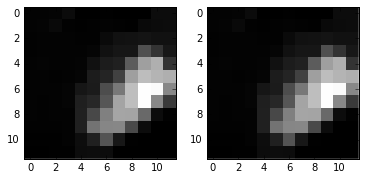

In [130]:
'''normali the image data'''
out_np = X[0]
X_out = (out_np - out_np.flatten().min())/(out_np.flatten().max() - out_np.flatten().min())
plt.subplot(1,2,1)
# plt.hist(X_out.flatten(), 100)
plt.imshow(X_out, cmap='gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(out_np, cmap='gray', interpolation='none')
np.max(X_out)
type(X)

In [131]:
X_lst = []
for image in X:
    X_out = (image - image.flatten().min())/(image.flatten().max() - image.flatten().min())
    X_lst.append(X_out)

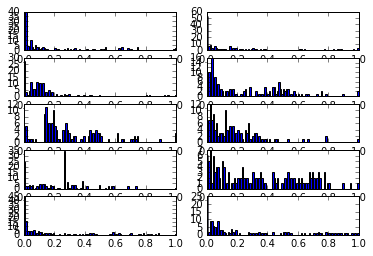

In [132]:
for item in true_lst[:10]:
    plt.subplot(5, 2,true_lst.index(item)+1)
    plt.hist(X_lst[item].flatten(),100)

In [133]:
window = [0.1, 0.2]

True

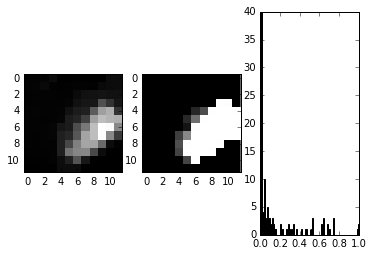

In [135]:
img_num = 0
window_img = np.clip(X_lst[img_num], window[0], window[1])
plt.subplot(1, 3, 1)
plt.imshow(X_lst[img_num], cmap='gray', interpolation='none')
plt.subplot(1,3, 2)
plt.imshow(window_img, cmap='gray', interpolation='none')
plt.subplot(1, 3, 3)
plt.hist(X_lst[img_num].flatten(), 100)
img_num in true_lst

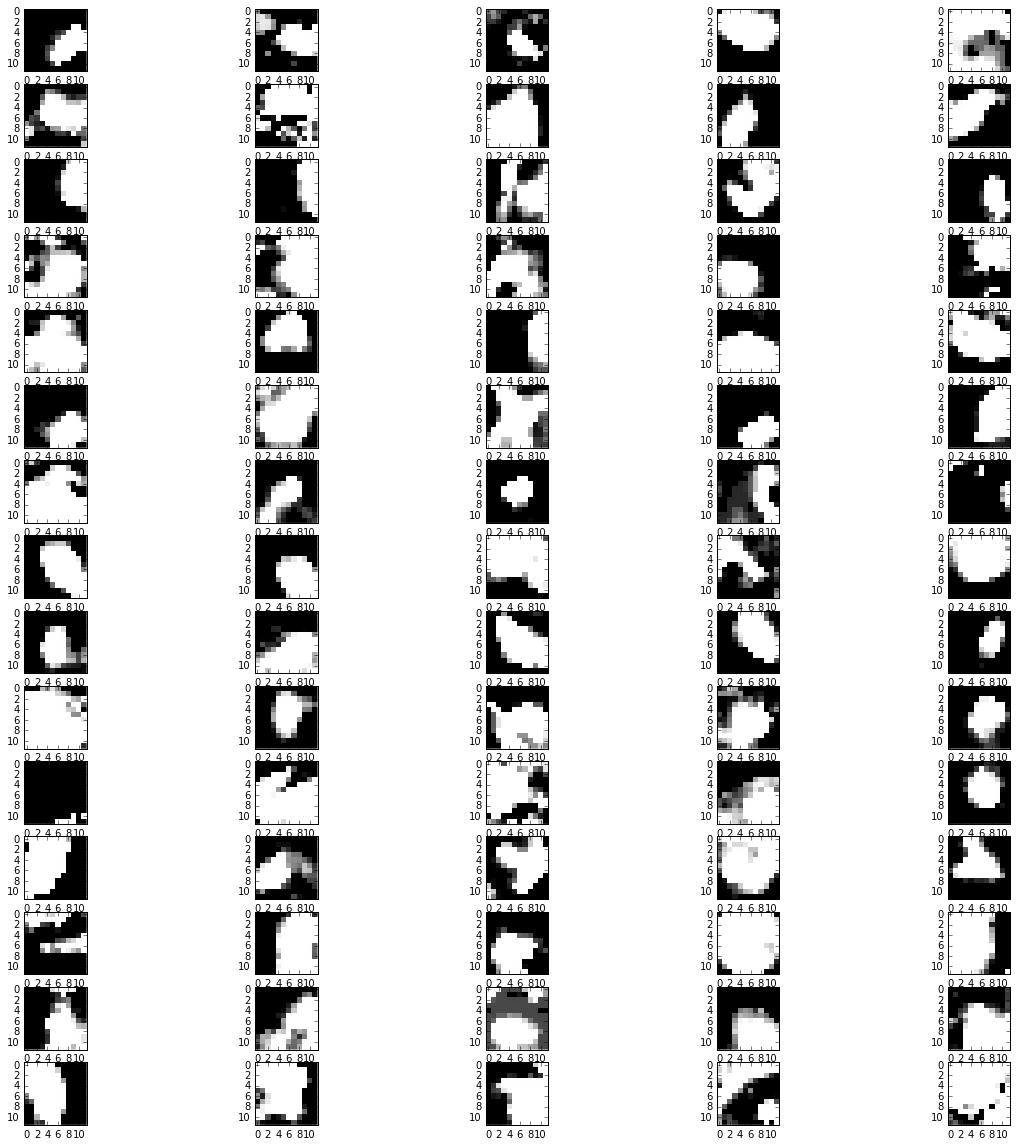

In [148]:
i = 1
tf_list = true_lst
for img_num in tf_list[:len(tf_list)]:
    window_img = np.clip(X_lst[img_num], window[0], window[1])
    plt.figure(num=len(tf_list), figsize=(20, 20), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(np.ceil(len(tf_list) / 5.0), 5, tf_list.index(img_num)+1)
    plt.imshow(window_img, cmap='gray', interpolation='none')
    i = i + 1

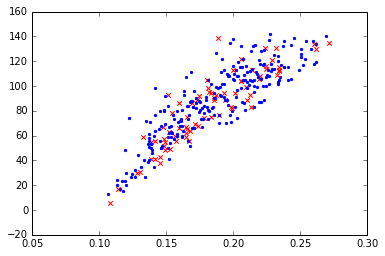

In [149]:
X_scatter = []
X_num_lst = []
for img in X_lst:
    mm = np.mean(np.clip(img, 0.1, 0.3))
    m1 = np.count_nonzero(np.clip(img, 0.1, 0.3) - 0.1)
    X_scatter.append(mm)
    X_num_lst.append(m1)

X_plt_true = []
X_num_plt_true = []

for item in true_lst:
    img = X_scatter[item]
    X_plt_true.append(img)
    num = X_num_lst[item]
    X_num_plt_true.append(num)
    
plt.scatter(X_plt_true, X_num_plt_true, marker='x', color='r')

X_plt_false = []
X_num_plt_false = []

for item in false_lst:
    img = X_scatter[item]
    X_plt_false.append(img)
    num = X_num_lst[item]
    X_num_plt_false.append(num)
    
plt.scatter(X_plt_false, X_num_plt_false, marker='.', color='b')

In [150]:
lss=[]
for item in X_lst:
    it = item.flatten()
    lss.append(it)

In [151]:
'''SVM play'''
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

X_svm = lss
y_svm = y
clf = svm.SVC(C=784.75997035146224, cache_size=100, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.00069519279617756048, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

clf.fit(lss, y_svm)  

SVC(C=784.759970351, cache_size=100, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.000695192796178,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [152]:
C_range = np.logspace(-5, 10, 20)
gamma_range = np.logspace(-10, 3, 20)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_svm, y_svm)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0000000000000001e-05, 'gamma': 1e-10} with a score of 0.76
